<a href="https://colab.research.google.com/github/puneetpushkar/IPL-Data-Analysis-with-PySpark/blob/main/IPL_Data_Analysis_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Section 01: Environment Setup

In [16]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [17]:
import findspark
findspark.init()
findspark.add_packages('mysql:mysql-connector-java:8.0.11')

In [24]:
import pyspark.sql
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [32]:
spark

In [46]:
ball_by_ball_df = spark.read.format("csv") \
    .option("header", True) \
    .load("/content/ipl_ball_by_ball.csv")

ipl_venue_df= spark.read.format("csv") \
    .option("header", True) \
    .load("/content/ipl_venue.csv")

ipl_matches_df = spark.read.format("csv") \
    .option("header", True) \
    .load("ipl_matches.csv")

In [47]:
ball_by_ball_df.printSchema()

root
 |-- match_id: string (nullable = true)
 |-- inning: string (nullable = true)
 |-- overs: string (nullable = true)
 |-- ball: string (nullable = true)
 |-- batsman: string (nullable = true)
 |-- non_striker: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- batsman_runs: string (nullable = true)
 |-- extra_runs: string (nullable = true)
 |-- total_runs: string (nullable = true)
 |-- non_boundary: string (nullable = true)
 |-- is_wicket: string (nullable = true)
 |-- dismissal_kind: string (nullable = true)
 |-- player_dismissed: string (nullable = true)
 |-- fielder: string (nullable = true)
 |-- extras_type: string (nullable = true)
 |-- batting_team: string (nullable = true)
 |-- bowling_team: string (nullable = true)



In [48]:
ipl_venue_df.printSchema()

root
 |-- venue_id: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- city: string (nullable = true)



In [49]:
ipl_matches_df.printSchema()

root
 |-- match_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- venue_id: string (nullable = true)
 |-- neutral_venue: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: string (nullable = true)
 |-- eliminator: string (nullable = true)
 |-- method: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)



In [50]:
# Creating table from dataframe

ipl_venue_df.createOrReplaceTempView("ipl_venue")
spark.sql("select * from ipl_venue")
ipl_matches_df.createOrReplaceTempView("ipl_matches")
spark.sql("select * from ipl_matches")
ball_by_ball_df.createOrReplaceTempView("ipl_ball_by_ball")
spark.sql("select * from ipl_ball_by_ball")

DataFrame[match_id: string, inning: string, overs: string, ball: string, batsman: string, non_striker: string, bowler: string, batsman_runs: string, extra_runs: string, total_runs: string, non_boundary: string, is_wicket: string, dismissal_kind: string, player_dismissed: string, fielder: string, extras_type: string, batting_team: string, bowling_team: string]

### Section 02: Analysis

##### Question A:
Find the top 3 venues which hosted the most number of eliminator
matches?

In [51]:
spark.sql(
"""
select v.venue, count(v.venue_id) venue_count from ipl_matches m 
join ipl_venue v on m.venue_id=v.venue_id
where m.eliminator = 'Y'
group by v.venue
order by venue_count desc
limit 3;
""").show()

+--------------------+-----------+
|               venue|venue_count|
+--------------------+-----------+
|Dubai Internation...|          3|
|Sheikh Zayed Stadium|          2|
|Sardar Patel Stad...|          1|
+--------------------+-----------+



##### Question B: 
Return most number of catches taken by a player in IPL history?

In [52]:
spark.sql(
"""
select fielder, count(dismissal_kind) NoOfCatches from ipl_ball_by_ball
where dismissal_kind = "caught"
group by fielder
order by NoOfCatches desc
limit 1;
""").show()

+----------+-----------+
|   fielder|NoOfCatches|
+----------+-----------+
|KD Karthik|        118|
+----------+-----------+



##### Question C:
Write a query to return a report for highest wicket taker in matches
which were affected by Duckworth-Lewis’s method (D/L method).

In [53]:
spark.sql(
"""
select m.match_id, bbb.bowler, count(bbb.bowler) NoOfWickets from ipl_ball_by_ball bbb
join ipl_matches m on m.match_id = bbb.match_id
where m.method = "D/L" and is_wicket = 1
group by m.match_id, bbb.bowler
order by NoOfWickets desc;
""").show()

+--------+---------------+-----------+
|match_id|         bowler|NoOfWickets|
+--------+---------------+-----------+
|  392183|     DL Vettori|          5|
|  336025|        M Ntini|          4|
|  980999|      YS Chahal|          4|
|  980943|       AB Dinda|          4|
| 1136566|       S Nadeem|          3|
| 1136592|       TA Boult|          3|
|  980997|       AB Dinda|          3|
| 1136592|     JD Unadkat|          3|
| 1082648|NM Coulter-Nile|          3|
|  980997|        A Zampa|          3|
|  980999|      SR Watson|          2|
| 1136578|         AJ Tye|          2|
|  733993|   MC Henriques|          2|
|  829807|   MC Henriques|          2|
|  980989|       R Ashwin|          2|
|  980943|       MR Marsh|          2|
|  829807|        D Wiese|          2|
|  392186|     SC Ganguly|          2|
|  501245|       L Balaji|          2|
|  501255|      JH Kallis|          2|
+--------+---------------+-----------+
only showing top 20 rows



##### Question D: 
Write a query to return a report for highest strike rate by a batsman in non
powerplay overs(7-20 overs)

In [54]:
spark.sql(
"""
select batsman, (sum(batsman_runs)/count(ball)*100) as strikeRate from ipl_ball_by_ball
where (extras_type not in ("wides","noballs")) 
and (overs >= 7 and overs <= 20)
group by batsman
order by strikeRate desc;
""").show()

+------------+------------------+
|     batsman|        strikeRate|
+------------+------------------+
|  B Stanlake|             250.0|
|Kamran Akmal|213.88888888888889|
|  ER Dwivedi|211.11111111111111|
|    Umar Gul|205.26315789473685|
| AC Blizzard|             200.0|
|    RS Sodhi|             200.0|
|    W Jaffer|             188.0|
|   DJM Short|187.09677419354838|
|   LJ Wright|             186.0|
|  AD Russell|181.85185185185185|
|Vishnu Vinod|             180.0|
|    V Sehwag|179.92351816443596|
|   KK Cooper|179.31034482758622|
|      MM Ali|178.28947368421052|
|  I Malhotra|             175.0|
|TU Deshpande|             175.0|
|    CH Gayle|172.80564263322884|
|   K Gowtham|171.15384615384613|
| Abdul Samad|170.76923076923077|
| BCJ Cutting|170.50359712230215|
+------------+------------------+
only showing top 20 rows



##### Question E.
Write a query to return a report for highest extra runs in a venue (stadium, city).

In [55]:
spark.sql(
"""
select v.venue, v.city, sum(bbb.extra_runs) extra_runs from ipl_ball_by_ball bbb
inner join ipl_matches as m on bbb.match_id=m.match_id
inner join ipl_venue as v on m.venue_id =v.venue_id
group by venue, v.city
order by extra_runs desc;
""").show()

+--------------------+----------+----------+
|               venue|      city|extra_runs|
+--------------------+----------+----------+
|M.Chinnaswamy Sta...| Bengaluru|    1355.0|
|    Wankhede Stadium|    Mumbai|    1232.0|
|        Eden Gardens|   Kolkata|    1215.0|
|    Feroz Shah Kotla|     Delhi|    1114.0|
|MA Chidambaram St...|   Chennai|     905.0|
|Rajiv Gandhi Inte...| Hyderabad|     900.0|
|Sawai Mansingh St...|    Jaipur|     791.0|
|Punjab Cricket As...|Chandigarh|     566.0|
|Dubai Internation...|     Dubai|     492.0|
|Sheikh Zayed Stadium| Abu Dhabi|     387.0|
|Dr DY Patil Sport...|    Mumbai|     320.0|
|Maharashtra Crick...|      Pune|     315.0|
|Sharjah Cricket S...|   Sharjah|     287.0|
|           Kingsmead|    Durban|     277.0|
|Punjab Cricket As...|Chandigarh|     271.0|
|   Brabourne Stadium|    Mumbai|     246.0|
|Subrata Roy Sahar...|      Pune|     237.0|
|     SuperSport Park| Centurion|     213.0|
|Himachal Pradesh ...|Dharamsala|     177.0|
|Sardar Pa

##### Question F: 
Write a query to return a report for the cricketers with the most number of players of
the match award in neutral venues

In [56]:
spark.sql(
"""
select m.player_of_match, count(m.player_of_match) Count_Of_Player_Of_Match from ipl_matches m
join ipl_venue v on m.venue_id = v.venue_id
where neutral_venue = 1
group by m.player_of_match
order by count(m.player_of_match) desc;
""").show()

+----------------+------------------------+
| player_of_match|Count_Of_Player_Of_Match|
+----------------+------------------------+
|      GJ Maxwell|                       3|
|       JH Kallis|                       3|
|       JP Duminy|                       3|
|       YK Pathan|                       3|
|    Yuvraj Singh|                       2|
|   KC Sangakkara|                       2|
|  Sandeep Sharma|                       2|
|    SR Tendulkar|                       2|
|     LRPL Taylor|                       2|
|        SK Raina|                       2|
|  AB de Villiers|                       2|
|       ML Hayden|                       2|
|DPMD Jayawardene|                       2|
|       RG Sharma|                       2|
|        DR Smith|                       2|
|  M Muralitharan|                       2|
|       MK Pandey|                       2|
|    AC Gilchrist|                       2|
|     S Badrinath|                       1|
|        V Sehwag|              

##### Question G: 
Write a query to get a list of top 10 players with the highest batting average

In [57]:
spark.sql(
"""
select Batsman_, sum(batsman_runs)/count(player_dismissed) as Average 
from
(
 (select batsman as Batsman_,batsman_runs,player_dismissed from IPL_BALL_BY_BALL where player_dismissed != 'NA')
)
group by Batsman_ 
order by Average desc;
""").show()

+---------------+------------------+
|       Batsman_|           Average|
+---------------+------------------+
|   CRD Fernando|               2.0|
|     KP Appanna|               1.0|
|    LH Ferguson|               1.0|
|      AA Noffke|               1.0|
|       CV Varun|               0.5|
|      SB Jakati|               0.5|
|     T Thushara|               0.5|
|     WD Parnell|0.4444444444444444|
|KB Arun Karthik|               0.4|
|       AC Voges|0.3333333333333333|
|        T Taibu|0.3333333333333333|
|    DS Kulkarni|0.3333333333333333|
|        T Kohli|0.3333333333333333|
|    BMAJ Mendis|0.3333333333333333|
|       Umar Gul|0.3333333333333333|
|    RJ Peterson|0.3333333333333333|
|    NL McCullum|0.3333333333333333|
|          B Lee|               0.3|
|       R Dhawan|0.2857142857142857|
|       S Narwal|              0.25|
+---------------+------------------+
only showing top 20 rows



##### Question H:
Write a query to find out who has officiated (as an umpire) the most
number of matches in IPL

In [58]:
spark.sql(
"""
select umpire, count(*) as No_of_Matches
from ((select umpire1 as umpire from ipl_matches) union all
      (select umpire2 from ipl_matches)
     ) ipl_matches
group by umpire
order by count(*) desc ;
""").show()
#Combing two similar columns by union and counting numbers on times they have officiated

+--------------------+-------------+
|              umpire|No_of_Matches|
+--------------------+-------------+
|              S Ravi|          121|
|     HDPK Dharmasena|           94|
|        AK Chaudhary|           87|
|       C Shamshuddin|           82|
|           M Erasmus|           65|
|           CK Nandan|           57|
|         Nitin Menon|           57|
|          SJA Taufel|           55|
|           Asad Rauf|           51|
|         VA Kulkarni|           50|
|        BNJ Oxenford|           48|
|         CB Gaffaney|           47|
|           RJ Tucker|           46|
|         BR Doctrove|           42|
|         RE Koertzen|           41|
|           Aleem Dar|           38|
|           BF Bowden|           37|
|            NJ Llong|           37|
|KN Ananthapadmana...|           33|
|      RK Illingworth|           31|
+--------------------+-------------+
only showing top 20 rows



##### Question I:  
Find venue details of the match where V Kohli scored his highest individual runs in
IPL.

In [59]:
spark.sql(
"""
select m.match_id, v.venue, v.city, sum(b.batsman_runs) TotalRuns from ipl_ball_by_ball as b
inner join ipl_matches as m on b.match_id=m.match_id
inner join ipl_venue as v on m.venue_id =v.venue_id
where b.batsman= 'V Kohli'
group by m.match_id, v.venue, v.city
order by sum(b.batsman_runs) desc limit 1; 
""").show()

+--------+--------------------+---------+---------+
|match_id|               venue|     city|TotalRuns|
+--------+--------------------+---------+---------+
|  980999|M.Chinnaswamy Sta...|Bengaluru|    113.0|
+--------+--------------------+---------+---------+



##### Question J: 
Please analyze how winning/losing tosses can impact a match and it's result?
(Bonus for Visualization here)

In [60]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col

# count data where match_winner = toss_winner
team_wins_df = ipl_matches_df.filter(F.col('winner')==F.col('toss_winner')).groupBy('winner').agg(F.count('winner').alias('team_wins'))

# count no of toss winner
toss_wins_df = ipl_matches_df.groupBy('toss_winner').count().orderBy('toss_winner')
#print(team_wins_df.show(2))
#print(toss_wins_df.show(2))

toss_wins_df = toss_wins_df.withColumnRenamed("toss_winner", "winner").withColumnRenamed("count", "toss_wins")

# join the two dataframes (team_wins_df & toss_wins_df)
team_toss_wins = team_wins_df.join(toss_wins_df.select('winner', 'toss_wins'), ['winner'])
team_toss_wins = team_toss_wins.withColumnRenamed("winner", "teams")


In [61]:
# converting spark dataframes to pandas dataframe

team_toss_wins = team_toss_wins.toPandas()

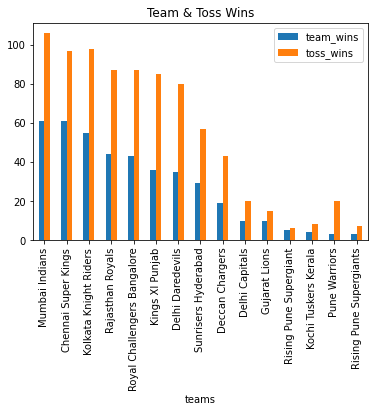

In [62]:
# Graph with respect to match wins vs toss wins

team_toss_wins = team_toss_wins.sort_values(by=['team_wins', 'toss_wins'], ascending = False)
team_toss_wins.plot(x="teams", y=["team_wins", "toss_wins"], kind="bar", title = "Team & Toss Wins")

In [63]:
win_count = 0
for value in ipl_matches_df.collect():
    if(value['toss_winner']==value['winner']):
        win_count += 1
print(f'The number of times the team winning toss have won: {win_count}')
prob = win_count/(ipl_matches_df.count())
print('The probability of winning if won the toss: {:.2f}' .format(prob))

The number of times the team winning toss have won: 418
The probability of winning if won the toss: 0.51


From the analysis we can say that :<br>
1. The team with highest no. of toss wins has mostly won the match most of the times.<br>
2. A team will have ***51%*** chance of winnning the match if it wins the toss

### Section 03: Expose Data

In [75]:
import sqlite3
import pandas as pd

# creating sqlite3 database
con = sqlite3.connect('iplmatches.db')

In [76]:
# load data

df = pd.read_csv('/content/ipl_ball_by_ball.csv')

# strip whitespace from headers
df.columns = df.columns.str.strip()

# drop data into database
df.to_sql("ipl_ball_by_ball", con)

ValueError: ignored

In [77]:
# load data
df = pd.read_csv('/content/ipl_venue.csv')

# strip whitespace from headers
df.columns = df.columns.str.strip()

# drop data into database
df.to_sql("ipl_venue", con)

ValueError: ignored

In [78]:
# load data
df = pd.read_csv('/content/ipl_matches.csv')

# strip whitespace from headers
df.columns = df.columns.str.strip()

# drop data into database
df.to_sql("ipl_matches", con)

ValueError: ignored

In [86]:
class Database:
    # constructor 
    def __init__(self):
        self.db_name = "iplmatches.db"
        
    def get_conn(self):
        try:
            con = sqlite3.connect(self.db_name)
            print("Database connected successfully")
            return con
        except:
            print("Unable to connect data base")
            
    def get_status(self,con):
        try:
            con.cursor()
            print("Database is connected")
        except Exception as ex:
            print("Database is not connected")
            
    def close_conn(self,con):
        try:
            con.close()
            print("Database connection closed successfully")
        except:
            print("Unable to close Database connection")
            
    # Question(A)
    def get_query1_result(self,con):
        cur = con.execute("""select v.venue, count(v.venue_id) venue_count from ipl_matches m 
                         join ipl_venue v on m.venue_id=v.venue_id
                        where m.eliminator = 'Y'
                        group by v.venue
                        order by venue_count desc
                            limit 3;""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
      
    # Question (B)
    def get_query2_result(self, con):
        cur = con.execute("""select fielder, count(dismissal_kind) NoOfCatches from ipl_ball_by_ball
                           where dismissal_kind = "caught"
                           group by fielder
                           order by NoOfCatches desc
                           limit 1;""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
    
    # Question (C)
    def get_query3_result(self, con):
        cur=con.execute("""select m.match_id, bbb.bowler, count(bbb.bowler) NoOfWickets from ipl_ball_by_ball bbb
                           join ipl_matches m on m.match_id = bbb.match_id
                           where m.method = "D/L" and is_wicket = 1
                           group by m.match_id, bbb.bowler
                           order by NoOfWickets desc;""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
    
    # Question (D)
    def get_query4_result(self, con):
        cur=con.execute("""select batsman, (sum(batsman_runs)/count(ball)*100) as strikeRate from ipl_ball_by_ball
                           where (extras_type not in ("wides","noballs")) 
                           and (overs >= 7 and overs <= 20)
                           group by batsman
                           order by strikeRate desc;""")

        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
    
    # Question (E)
    def get_query5_result(self, con):
        cur=con.execute("""select v.venue, v.city, sum(bbb.extra_runs) extra_runs from ipl_ball_by_ball bbb
                           inner join ipl_matches as m on bbb.match_id=m.match_id
                           inner join ipl_venue as v on m.venue_id =v.venue_id
                           group by venue, v.city
                           order by extra_runs desc;""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
    
    # Question (F)
    def get_query6_result(self, con):
        cur=con.execute("""select m.player_of_match, count(m.player_of_match) from ipl_matches m
                           join ipl_venue v on m.venue_id = v.venue_id
                           where neutral_venue = 1
                           group by m.player_of_match
                           order by count(m.player_of_match) desc;""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
    
    # Question (H)
    def get_query7_result(self, con):
        cur = con.execute("""select umpire, count(*) as umpire_count from
                               (select umpire1 as umpire from ipl_matches union all
                                 select umpire2 from ipl_matches) ipl_matches
                                    group by ipl_matches.umpire
                                    order by count(*) desc""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data
    
    # Question (I)
    def get_query8_result(self, con):
        cur= con.execute("""select m.match_id, v.venue, v.city, sum(b.batsman_runs) TotalRuns from ipl_ball_by_ball as b
                            inner join ipl_matches as m on b.match_id=m.match_id
                            inner join ipl_venue as v on m.venue_id =v.venue_id
                            where b.batsman= 'V Kohli'
                            group by m.match_id, v.venue, v.city
                            order by sum(b.batsman_runs) desc limit 1;""")
        desc = cur.description
        column_names = [col[0] for col in desc]
        data = [dict(zip(column_names, row))  
        for row in cur.fetchall()]
        return data


In [87]:
# creating class database object
db = Database()
 
# calling the instance method using the object db
con = db.get_conn()

Database connected successfully


In [88]:
qry1_result = db.get_query1_result(con);
print(qry1_result)

[{'venue': 'Dubai International Cricket Stadium', 'venue_count': 3}, {'venue': 'Sheikh Zayed Stadium', 'venue_count': 2}, {'venue': 'Feroz Shah Kotla', 'venue_count': 1}]


In [89]:
qry2_result = db.get_query2_result(con);
print(qry2_result)

[{'fielder': 'KD Karthik', 'NoOfCatches': 118}]


In [90]:
qry3_result = db.get_query3_result(con);
print(qry3_result)

[{'match_id': 392183, 'bowler': 'DL Vettori', 'NoOfWickets': 5}, {'match_id': 336025, 'bowler': 'M Ntini', 'NoOfWickets': 4}, {'match_id': 980943, 'bowler': 'AB Dinda', 'NoOfWickets': 4}, {'match_id': 980999, 'bowler': 'YS Chahal', 'NoOfWickets': 4}, {'match_id': 980997, 'bowler': 'A Zampa', 'NoOfWickets': 3}, {'match_id': 980997, 'bowler': 'AB Dinda', 'NoOfWickets': 3}, {'match_id': 1082648, 'bowler': 'NM Coulter-Nile', 'NoOfWickets': 3}, {'match_id': 1136566, 'bowler': 'S Nadeem', 'NoOfWickets': 3}, {'match_id': 1136592, 'bowler': 'JD Unadkat', 'NoOfWickets': 3}, {'match_id': 1136592, 'bowler': 'TA Boult', 'NoOfWickets': 3}, {'match_id': 336022, 'bowler': 'JR Hopes', 'NoOfWickets': 2}, {'match_id': 336022, 'bowler': 'RR Powar', 'NoOfWickets': 2}, {'match_id': 392186, 'bowler': 'SC Ganguly', 'NoOfWickets': 2}, {'match_id': 501215, 'bowler': 'NLTC Perera', 'NoOfWickets': 2}, {'match_id': 501215, 'bowler': 'R Ashwin', 'NoOfWickets': 2}, {'match_id': 501245, 'bowler': 'L Balaji', 'NoOfWi

In [91]:
qry4_result = db.get_query4_result(con);
print(qry4_result)

[{'batsman': 'A Ashish Reddy', 'strikeRate': 0}, {'batsman': 'A Chopra', 'strikeRate': 0}, {'batsman': 'A Flintoff', 'strikeRate': 0}, {'batsman': 'A Kumble', 'strikeRate': 0}, {'batsman': 'A Mishra', 'strikeRate': 0}, {'batsman': 'A Mithun', 'strikeRate': 0}, {'batsman': 'A Nehra', 'strikeRate': 0}, {'batsman': 'A Symonds', 'strikeRate': 0}, {'batsman': 'AA Bilakhia', 'strikeRate': 0}, {'batsman': 'AA Jhunjhunwala', 'strikeRate': 0}, {'batsman': 'AB Agarkar', 'strikeRate': 0}, {'batsman': 'AB Dinda', 'strikeRate': 0}, {'batsman': 'AB McDonald', 'strikeRate': 0}, {'batsman': 'AB de Villiers', 'strikeRate': 0}, {'batsman': 'AC Gilchrist', 'strikeRate': 0}, {'batsman': 'AC Voges', 'strikeRate': 0}, {'batsman': 'AD Mascarenhas', 'strikeRate': 0}, {'batsman': 'AD Mathews', 'strikeRate': 0}, {'batsman': 'AD Russell', 'strikeRate': 0}, {'batsman': 'AJ Finch', 'strikeRate': 0}, {'batsman': 'AJ Tye', 'strikeRate': 0}, {'batsman': 'AL Menaria', 'strikeRate': 0}, {'batsman': 'AM Nayar', 'strikeR

In [92]:
qry5_result = db.get_query5_result(con);
print(qry5_result)

[{'venue': 'M.Chinnaswamy Stadium', 'city': 'Bengaluru', 'extra_runs': 1355}, {'venue': 'Wankhede Stadium', 'city': 'Mumbai', 'extra_runs': 1232}, {'venue': 'Eden Gardens', 'city': 'Kolkata', 'extra_runs': 1215}, {'venue': 'Feroz Shah Kotla', 'city': 'Delhi', 'extra_runs': 1114}, {'venue': 'MA Chidambaram Stadium, Chepauk', 'city': 'Chennai', 'extra_runs': 905}, {'venue': 'Rajiv Gandhi International Stadium, Uppal', 'city': 'Hyderabad', 'extra_runs': 900}, {'venue': 'Sawai Mansingh Stadium', 'city': 'Jaipur', 'extra_runs': 791}, {'venue': 'Punjab Cricket Association Stadium, Mohali', 'city': 'Chandigarh', 'extra_runs': 566}, {'venue': 'Dubai International Cricket Stadium', 'city': 'Dubai', 'extra_runs': 492}, {'venue': 'Sheikh Zayed Stadium', 'city': 'Abu Dhabi', 'extra_runs': 387}, {'venue': 'Dr DY Patil Sports Academy', 'city': 'Mumbai', 'extra_runs': 320}, {'venue': 'Maharashtra Cricket Association Stadium', 'city': 'Pune', 'extra_runs': 315}, {'venue': 'Sharjah Cricket Stadium', 'c

In [93]:
qry6_result = db.get_query6_result(con);
print(qry6_result)

[{'player_of_match': 'GJ Maxwell', 'count(m.player_of_match)': 3}, {'player_of_match': 'JH Kallis', 'count(m.player_of_match)': 3}, {'player_of_match': 'JP Duminy', 'count(m.player_of_match)': 3}, {'player_of_match': 'YK Pathan', 'count(m.player_of_match)': 3}, {'player_of_match': 'AB de Villiers', 'count(m.player_of_match)': 2}, {'player_of_match': 'AC Gilchrist', 'count(m.player_of_match)': 2}, {'player_of_match': 'DPMD Jayawardene', 'count(m.player_of_match)': 2}, {'player_of_match': 'DR Smith', 'count(m.player_of_match)': 2}, {'player_of_match': 'KC Sangakkara', 'count(m.player_of_match)': 2}, {'player_of_match': 'LRPL Taylor', 'count(m.player_of_match)': 2}, {'player_of_match': 'M Muralitharan', 'count(m.player_of_match)': 2}, {'player_of_match': 'MK Pandey', 'count(m.player_of_match)': 2}, {'player_of_match': 'ML Hayden', 'count(m.player_of_match)': 2}, {'player_of_match': 'RG Sharma', 'count(m.player_of_match)': 2}, {'player_of_match': 'SK Raina', 'count(m.player_of_match)': 2},

In [94]:
qry7_result = db.get_query7_result(con);
print(qry7_result)

[{'umpire': 'S Ravi', 'umpire_count': 121}, {'umpire': 'HDPK Dharmasena', 'umpire_count': 94}, {'umpire': 'AK Chaudhary', 'umpire_count': 87}, {'umpire': 'C Shamshuddin', 'umpire_count': 82}, {'umpire': 'M Erasmus', 'umpire_count': 65}, {'umpire': 'CK Nandan', 'umpire_count': 57}, {'umpire': 'Nitin Menon', 'umpire_count': 57}, {'umpire': 'SJA Taufel', 'umpire_count': 55}, {'umpire': 'Asad Rauf', 'umpire_count': 51}, {'umpire': 'VA Kulkarni', 'umpire_count': 50}, {'umpire': 'BNJ Oxenford', 'umpire_count': 48}, {'umpire': 'CB Gaffaney', 'umpire_count': 47}, {'umpire': 'RJ Tucker', 'umpire_count': 46}, {'umpire': 'BR Doctrove', 'umpire_count': 42}, {'umpire': 'RE Koertzen', 'umpire_count': 41}, {'umpire': 'Aleem Dar', 'umpire_count': 38}, {'umpire': 'BF Bowden', 'umpire_count': 37}, {'umpire': 'NJ Llong', 'umpire_count': 37}, {'umpire': 'KN Ananthapadmanabhan', 'umpire_count': 33}, {'umpire': 'RK Illingworth', 'umpire_count': 31}, {'umpire': 'SK Tarapore', 'umpire_count': 31}, {'umpire': 

In [95]:
qry8_result = db.get_query8_result(con);
print(qry8_result)

[{'match_id': 980999, 'venue': 'M.Chinnaswamy Stadium', 'city': 'Bengaluru', 'TotalRuns': 113}]


In [96]:
db.close_conn(con)

Database connection closed successfully
